In [1]:
### Script for using MOFA factors as predictors

#############################################
# Prerequisites - Load Libraries

In [2]:
source('MS0_Libraries.r')


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union



Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
   

In [3]:
source('MS4_Plot_Config.r')

###############################################
# Preqrequisites Configurations & Parameters

In [4]:
data_path = '../data/current'

In [5]:
result_path = '../results/current'

In [6]:
data_path

[1] "../data/current"

In [7]:
### Data to load for Factors and Gene Expression

version = 'V_FINAL_INTEGRATED_FALSE'

# Load Data

## Sample Data

In [8]:
path = paste0(result_path, '/00_Data_Overview/Available_Data_per_Sample_Overview.csv')
all_samples_info = read.csv(path)
print(file.info(path)$mtime)

[1] "2022-06-16 14:38:20 CEST"


In [9]:
path = paste0(result_path, '/00_Data_Overview/Merged_Sample_Meta_Data.csv')
sample_data = read.csv(path)
print(file.info(path)$mtime)

[1] "2022-06-16 14:38:20 CEST"


In [12]:
#patients_filter = unique(sample_data$sample_id[is.na(str_extract(sample_data$sample_id, 'k'))])  # use only acs samples
patients_filter = unique(sample_data$sample_id) #  use all samples

In [14]:
# Add new columns for later prediction

In [15]:
# Summarize good and intermediate outcome    
sample_data$delta_ef_value_class_summarized = sample_data$delta_ef_value_class
sample_data$delta_ef_value_class_summarized[sample_data$delta_ef_value_class %in% c('intermediate')] = 'good'

In [16]:
unique(sample_data$delta_ef_value_class_summarized)

[1] NA     "bad"  "good"

In [17]:
## Concatenate outcome with class

In [18]:
sample_data$tp_outcome = paste0(sample_data$measurement, '_', sample_data$delta_ef_value_class_summarized)

In [19]:
unique(sample_data$tp_outcome)

[1] "TP0_NA"   "TP1_NA"   "TP2_NA"   "TP3_NA"   "TP4_NA"   "TP1_bad" 
 [7] "TP2_bad"  "TP3_bad"  "TP4_bad"  "TP1_good" "TP2_good" "TP3_good"
[13] "TP4_good"

In [22]:
sample_data %>% group_by(tp_outcome) %>% count()

tp_outcome,n
<chr>,<int>
TP0_NA,34
TP1_bad,7
TP1_good,15
TP1_NA,7
TP2_bad,8
TP2_good,14
TP2_NA,7
TP3_bad,7
TP3_good,14


## Factor Data to use

In [25]:
path = paste0(result_path, '/E-Analysis/Factor_Data_', version, '.csv')
factor_data = read.csv(path)
print(file.info(path)$mtime)
#factor_data = read.csv(paste0(result_path, '/E-Analysis/E10_Factor_Data_REDUCED' , version ,'.csv'))

[1] "2023-01-18 15:19:14 CET"


In [27]:
head(factor_data,4)

,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,⋯,Factor12,Factor13,Factor14,Factor15,Factor16,Factor17,Factor18,Factor19,Factor20,sample_id
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,0.4811325,-0.2731317,1.4988169,-0.4135678,1.5052706,-0.92308998,-0.3904185,-0.1944797,0.16486799,-0.558130047,⋯,1.371875754,0.18829559,-0.30821631,-0.47997108,0.34688969,0.56926106,0.416665730,-0.60204874,-0.03085489,k1
2,0.8920603,-0.7547770,0.3501023,-0.1524478,0.4074517,-0.04596939,0.6276925,-1.1656937,-0.05003504,-0.338034341,⋯,-0.102028456,0.11991185,0.20967181,0.09246619,0.13351102,-0.04905520,-0.001722867,0.07838055,-0.03818913,k10
3,-1.2439808,-0.9826224,-0.8230479,-0.3559941,1.0458397,0.11800347,-0.2770340,-0.1901323,-0.10959612,-0.479903608,⋯,-0.015925683,-0.04062541,0.04315219,-0.02329634,-0.02298920,0.03253449,0.177102131,0.11100223,-0.02994567,k11
4,-1.9847781,-1.6711527,-1.0857874,-0.4570102,0.6403206,-0.37214375,-0.9344379,-0.1916442,0.03676072,-0.004778085,⋯,0.001169425,0.03116989,0.14784586,0.48202979,0.01680141,0.01807012,0.288699222,-0.15412217,-0.10906315,k12


## Normalized Gene Expression Data

In [28]:
path = paste0(result_path, '/E-Analysis/Combined_Data_',str_replace(version, '_FALSE', ''),'.csv')
data_long = read.csv(path)
print(file.info(path)$mtime)

[1] "2023-01-18 14:51:49 CET"


In [30]:
data_long$X = NULL

# Prepare data

In [34]:
### Merge the potential different features for prediction

In [35]:
## Add factor data

In [36]:
data = merge(factor_data, unique(sample_data[,c('sample_id', 'classification', 'measurement', 'delta_ef_value_class', 'delta_ef_value_class_summarized', 'tp_outcome', 'CK', 'CK_MB', 'Troponin', 'CRP')]), by.x = 'sample_id', by.y = 'sample_id')

In [38]:
## Add normalized gene expression values of selected features

In [39]:
unique(data_long$variable[!is.na(str_extract(data_long$variable, 'CD53'))])

[1] "X0_T.cell.CD4__CD53"               "X1_T.cell.CD8__CD53"              
 [3] "X10_B.cell__CD53"                  "X11_T.cell.CD4__CD53"             
 [5] "X12_Monocytes...CD16_FCGR3A__CD53" "X3_NK__CD53"                      
 [7] "X4_Monocytes...CD14__CD53"         "X6_Monocytes...CD14__CD53"        
 [9] "X7_Monocytes...CD14__CD53"         "X8_B.cell__CD53"                  
[11] "X9_Monocytes...CD16_FCGR3A__CD53"

In [40]:
features = c('CK', 'CK_MB', 'Troponin', 'CRP', 'X3_NK__TXNIP','X3_NK__PRF1', 'X3_NK__LITAF' , 'X3_NK__GZMB', 'X3_NK__FYN', 'X3_NK__CST7', 'X3_NK__CD53')

In [41]:
gene_expression_data = data_long[data_long$variable %in% features,]

In [42]:
gene_expression_data = gene_expression_data %>% dcast(sample_id ~ variable, value.var = 'value')

In [43]:
colnames(gene_expression_data) = paste0('Normalized_', colnames(gene_expression_data))

In [45]:
nrow(data)

[1] 128

In [46]:
data = merge(data, gene_expression_data, by.x = 'sample_id', by.y = 'Normalized_sample_id')

In [47]:
nrow(data)

[1] 128

In [48]:
### Add score values for ccs vs. no_ccs differentiation

In [49]:
data = merge(data, ccs_scores, all.x = TRUE)

In [50]:
nrow(data)

[1] 128

# Prediction Factor 4 TP1

In [52]:
data$CK = as.numeric(data$CK)
data$Troponin = as.numeric(data$Troponin)
data$CRP = as.numeric(data$CRP)

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


In [53]:
prediction_vars = c( 'Factor4',  'Normalized_CK', 'Normalized_CRP', 'Normalized_Troponin')

In [54]:
prediction_group = 'tp_outcome'
prediction_subset = c('TP1_good', 'TP1_bad')

In [55]:
prediction_data = data[,c(prediction_vars, prediction_group)]
prediction_data$y = prediction_data[,prediction_group]
prediction_data = prediction_data[prediction_data$y %in% prediction_subset,]

prediction_data$y[prediction_data$y == prediction_subset[2]] = 1  # predict BAD outcome 
prediction_data$y[prediction_data$y == prediction_subset[1]] = 0  # good outcome as control

In [56]:
## Check in which direction to adjust
prediction_data %>% group_by(tp_outcome,y) %>% summarise(across(everything(), mean, na.rm =TRUE))

# predict bad --> higher values for bad

`summarise()` has grouped output by 'tp_outcome'. You can override using the
`.groups` argument.


tp_outcome,y,Factor4,Normalized_CK,Normalized_CRP,Normalized_Troponin
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
TP1_bad,1,-1.1259212,0.9443535,-0.6691209,0.7195349
TP1_good,0,-0.6298132,0.6861117,-0.6469700,0.2787430


In [57]:
prediction_data %>% group_by(tp_outcome) %>% count()

tp_outcome,n
<chr>,<int>
TP1_bad,6
TP1_good,13


In [58]:
# Adjust sign of Factor values
prediction_data$Factor4 = -1*prediction_data$Factor4
prediction_data$Normalized_CRP = -1* prediction_data$Normalized_CRP

In [59]:
# Transform and scale scores of prediction variables (to be between 0 and 1)

In [60]:
prediction_data = cbind( prediction_data[,c('y', prediction_group)],
      apply(prediction_data[,prediction_vars], MARGIN = 2, FUN = function(x){
    (x - min(x, na.rm = TRUE)) / (max(x, na.rm = TRUE) - min(x, na.rm = TRUE))}))

In [68]:
## Alternative use GGPLOT IMPL

In [69]:
prediction_data_long = melt(prediction_data)

Using y, tp_outcome as id variables



In [70]:
prediction_data_long = prediction_data_long[!is.na(prediction_data_long$value),]

In [71]:
amount_samples = prediction_data_long %>% group_by(variable) %>% count()

In [72]:
prediction_data_long = merge(prediction_data_long, amount_samples)

In [73]:
prediction_data_long$variable_w_n = paste0(prediction_data_long$variable, ' (n=', prediction_data_long$n, ')')

In [74]:
head(prediction_data_long,2)

,variable,y,tp_outcome,value,n,variable_w_n
,<fct>,<chr>,<chr>,<dbl>,<int>,<chr>
1,Factor4,1,TP1_bad,0.4734997,19,Factor4 (n=19)
2,Factor4,1,TP1_bad,0.8558891,19,Factor4 (n=19)


In [75]:
# Figure Name
figure_name = 'FIG10_E9_ROC_Factor4_TP1'

In [76]:
# Sizes of the plot
width_par = 2
height_par = 2

In [77]:
xtitle = xlab( 'False Positive Fraction')
ytitle  = ylab('Sensititity')

In [78]:
auc_values = data.frame()

In [79]:
for(i in unique(prediction_data_long$variable)){
    calc_auc = data.frame(variable = i, 
                          auc = auc(prediction_data_long$y[prediction_data_long$variable == i], prediction_data_long$value[prediction_data_long$variable == i])
                          )
    auc_values = rbind(auc_values, calc_auc)
    }

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



In [80]:
auc_values

variable,auc
<chr>,<auc>
Factor4,0.8333333
Normalized_CK,0.6025641
Normalized_CRP,0.5181818
Normalized_Troponin,0.6666667


In [81]:
### Save AUC values

In [82]:
write.csv(auc_values, paste0(result_path,'/Supplementary/SUPP_E9_Factor4_ROC_Plot_AUC_values.csv'), row.names = FALSE)

In [83]:
auc(prediction_data_long$y[prediction_data_long$variable == 'Factor4'], prediction_data_long$value[prediction_data_long$variable == 'Factor4'])

Setting levels: control = 0, case = 1

Setting direction: controls < cases



Area under the curve: 0.8333

In [84]:
## Specify Plot
rocplot = ggplot(prediction_data_long, aes(m = value, d = as.numeric(y), color = variable_w_n, linetype= variable_w_n))+ geom_roc(n.cuts=0,labels=FALSE, size = 0.5)

In [85]:
unique(prediction_data_long$variable_w_n)

[1] "Factor4 (n=19)"             "Normalized_CK (n=19)"      
[3] "Normalized_CRP (n=16)"      "Normalized_Troponin (n=19)"

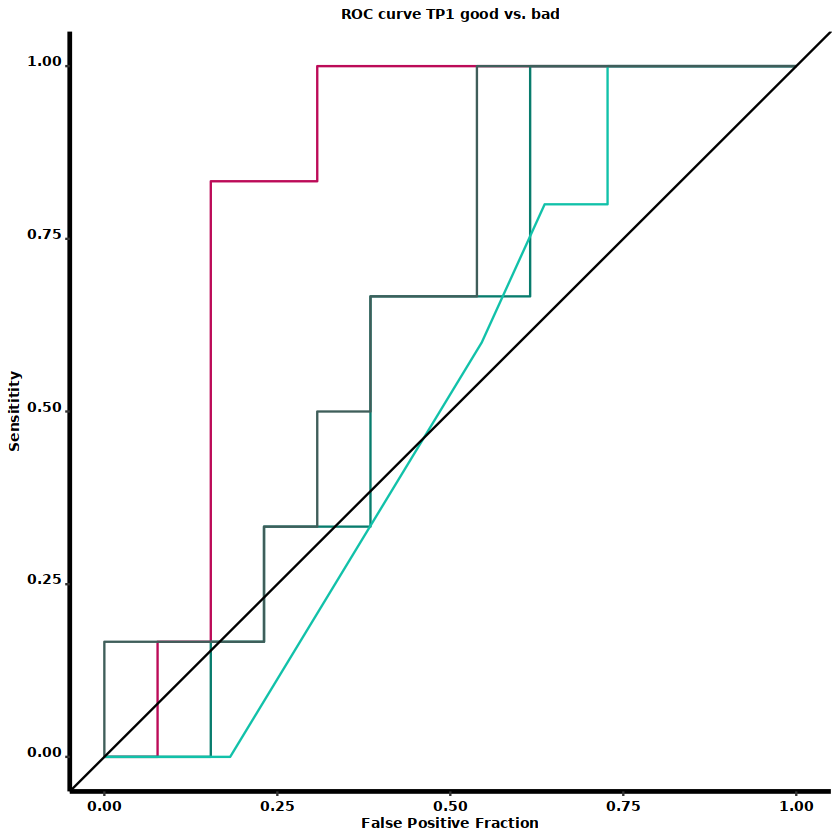

In [86]:
## Configuration + Modification of plot
roc_plot = rocplot + 
    plot_config + 
    xtitle + 
    ytitle + 
    ggtitle('ROC curve TP1 good vs. bad') +
    geom_abline(slope = 1, intercept = 0) +     
    scale_color_manual(values = c('Factor1 (n=21)' = "#BC0B58",
                                  'Factor4 (n=19)' = "#BC0B58",
                                  'Normalized_CK (n=19)' = "#087C6D",
                                  'Normalized_CRP (n=16)'="#11C1A9",
                                  'Normalized_Troponin (n=19)'="#3F5E5A"
                                 ))+
   scale_linetype_manual(values = c('Factor1 (n=21)' = "dashed",
                                    'Factor4 (n=19)' = "solid",
                                  'Normalized_CK (n=19)' = "solid",
                                  'Normalized_CRP (n=16)'="solid",
                                  'Normalized_Troponin (n=19)'="solid"
                                 ))+
    theme(legend.position = 'none')

#legend_roc = get_legend(roc_plot)
    

roc_plot

In [87]:
pdf(paste0('figures/Final_Figures/', figure_name, version, '.pdf'), width =width_par, height =height_par)
print(roc_plot)
dev.off()

png 
  2

In [88]:
color_data = data.frame(description = c('Factor4 (n=19)', 'Normalized_CK (n=19)',  'Normalized_CRP (n=16)',  'Normalized_Troponin (n=19)'),
                        color = c( "#BC0B58","#087C6D","#11C1A9","#3F5E5A"))

In [89]:
# Test calculation of ROC values

# prediction_data[!is.na(prediction_data$Normalized_CRP ),]

In [90]:
### Seperately define legend

In [91]:
legend_add  = Legend(labels = unique(color_data$description), labels_gp = gpar(fontsize = 8),legend_gp =list(col = unique(c(unique(color_data$color)))), 
    nrow = 4, type = 'lines') 

In [92]:
legend_add_vertical = packLegend(legend_add, direction = "horizontal")

In [93]:
pdf(paste0('figures/Final_Figures/ROC_Factor4_Legend_Text', '.pdf'), 
    width =2, 
    height = 0.7)
draw(legend_add_vertical)
dev.off()

png 
  2

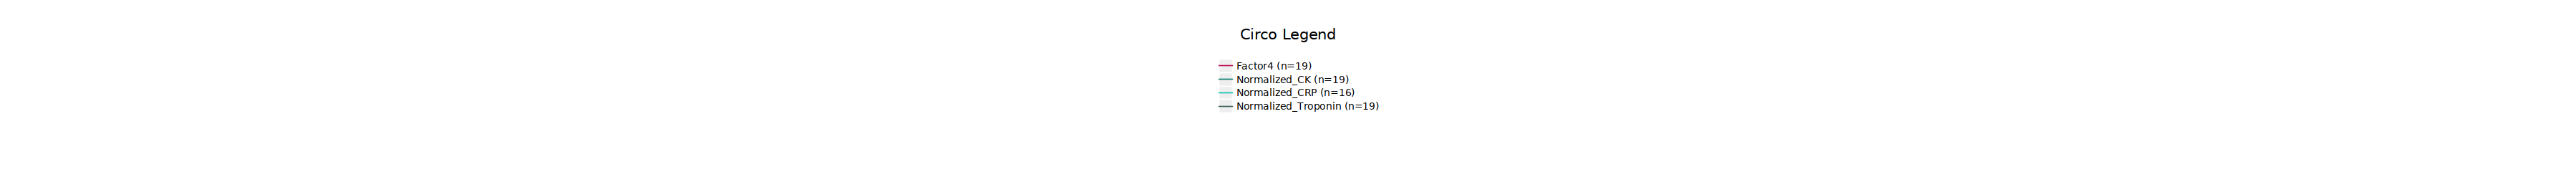

In [94]:
options(repr.plot.width=30, repr.plot.height=2)
draw(legend_add_vertical, test = "Circo Legend")

# Prediction Factor 4 TP1 (taking into account other TPs for all variables)

In [95]:
prediction_vars = c('Factor4',  'Normalized_CK', 'Normalized_Troponin')

In [96]:
prediction_group = 'tp_outcome'
prediction_subset = c('TP1_good', 'TP1_bad')

In [97]:
#colnames(data)

In [98]:
prediction_data = data[,c(prediction_vars, prediction_group, 'sample_id')]
prediction_data$y = prediction_data[,prediction_group]


In [99]:
prediction_data$sample = str_replace(prediction_data$sample_id, '\\..*', '')

In [100]:
add_features = prediction_data %>% group_by(sample) %>% summarise(Mean_CK = mean(Normalized_CK, na.rm = TRUE), Max_CK = max(Normalized_CK, na.rm = TRUE), Mean_Troponin = mean(Normalized_Troponin, na.rm = TRUE), Max_Troponin = max(Normalized_Troponin, na.rm = TRUE))

Warning message in max(Normalized_CK, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(Normalized_CK, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(Normalized_CK, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(Normalized_CK, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(Normalized_CK, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(Normalized_CK, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(Normalized_Troponin, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(Normalized_Troponin, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(Normalized_Troponin, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(Normalized_Troponin, na.rm = TRU

In [102]:
colnames(add_features)[!colnames(add_features) == 'sample']

[1] "Mean_CK"       "Max_CK"        "Mean_Troponin" "Max_Troponin"

In [103]:
prediction_data = merge(prediction_data[,c('sample', 'y', 'tp_outcome', 'Factor4')], add_features)

In [105]:
prediction_data = prediction_data[prediction_data$y %in% prediction_subset,]

prediction_data$y[prediction_data$y == prediction_subset[2]] = 1  # predict BAD outcome 
prediction_data$y[prediction_data$y == prediction_subset[1]] = 0  # good outcome as control

In [107]:
# Adjust sign of Factor values
prediction_data$Factor4 = -1*prediction_data$Factor4

In [108]:
# Transform and scale scores of prediction variables (to be between 0 and 1)

In [109]:
prediction_data = cbind( prediction_data[,c('y', prediction_group)],
      apply(prediction_data[,c('Factor4', colnames(add_features)[!colnames(add_features) == 'sample'])], MARGIN = 2, FUN = function(x){
    (x - min(x, na.rm = TRUE)) / (max(x, na.rm = TRUE) - min(x, na.rm = TRUE))}))

In [110]:
head(prediction_data,5)

,y,tp_outcome,Factor4,Mean_CK,Max_CK,Mean_Troponin,Max_Troponin
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
36,1,TP1_bad,0.4734997,1.0000000,0.7503890,1.0000000,1.0000000
45,1,TP1_bad,0.8558891,0.4562227,0.5261785,0.5556089,0.6342725
49,1,TP1_bad,0.7560452,0.4847296,0.4550662,0.4835328,0.5974694
53,0,TP1_good,1.0000000,0.6155006,0.4283336,0.4316984,0.4713510
60,1,TP1_bad,0.7118677,0.2195981,0.2955057,0.3321533,0.4162823


In [117]:
## Alternative use GGPLOT IMPL

In [118]:
prediction_data_long = melt(prediction_data)

Using y, tp_outcome as id variables



In [119]:
head(prediction_data_long,2)

,y,tp_outcome,variable,value
,<chr>,<chr>,<fct>,<dbl>
1,1,TP1_bad,Factor4,0.4734997
2,1,TP1_bad,Factor4,0.8558891


In [120]:
prediction_data_long = prediction_data_long[!is.na(prediction_data_long$value),]

In [121]:
prediction_data_long = prediction_data_long[!is.na(prediction_data_long$value),]

In [122]:
amount_samples = prediction_data_long %>% group_by(variable) %>% count()

In [123]:
prediction_data_long = merge(prediction_data_long, amount_samples)

In [124]:
prediction_data_long$variable_w_n = paste0(prediction_data_long$variable, ' (n=', prediction_data_long$n, ')')

In [125]:
# Figure Name
figure_name = 'FIG7_E9_ROC_Factor4_TP1_V2'

In [126]:
# Sizes of the plot
width_par = 4
height_par = 2

In [127]:
xtitle = xlab( 'False Positive Fraction')
ytitle  = ylab('Sensititity')

In [128]:
## Specify Plot
rocplot = ggplot(prediction_data_long, aes(m = value, d = as.numeric(y), color = variable_w_n))+ geom_roc(n.cuts=0,labels=FALSE, size = 0.5)

In [129]:
unique(prediction_data_long$variable_w_n )

[1] "Factor4 (n=19)"       "Max_CK (n=19)"        "Max_Troponin (n=19)" 
[4] "Mean_CK (n=19)"       "Mean_Troponin (n=19)"

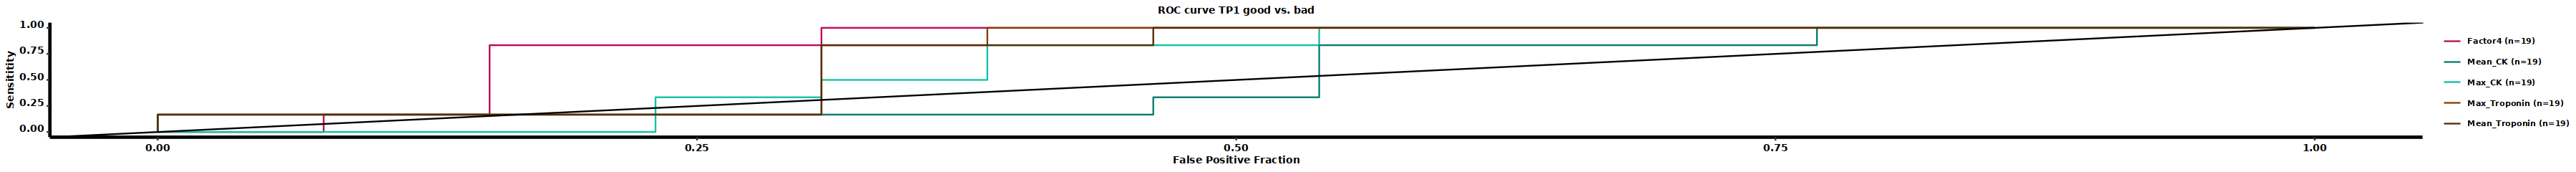

In [130]:
## Configuration + Modification of plot
roc_plot = rocplot + 
    plot_config + 
    xtitle + 
    ytitle + 
     scale_color_manual(values = c('Factor4 (n=19)' = "#BC0B58",
                                      'Mean_CK (n=19)' = "#087C6D",
                                      'Max_CK (n=19)'="#11C1A9",
                                   'Max_Troponin (n=19)' = '#863F06',
                                   'Mean_Troponin (n=19)' = '#5B2A03'
                                     ))+
       scale_linetype_manual(values = c('Factor4 (n=19)' = "solid",
                                      'Mean_CK (n=19)' = "solid",
                                      'Max_CK (n=19)'="solid",
                                               'Max_Troponin (n=19)'="solid",
                                               'Mean_Troponin (n=19)'="solid"
                                     ))+
    ggtitle('ROC curve TP1 good vs. bad') +
    geom_abline(slope = 1, intercept = 0)

roc_plot

In [131]:
pdf(paste0('figures/Final_Figures/', figure_name, version, '.pdf'), width =width_par, height =height_par)
print(roc_plot)
dev.off()

png 
  2

In [132]:
# Test calculation of ROC values

# prediction_data[!is.na(prediction_data$Normalized_CRP ),]

In [133]:
auc_values = data.frame()

In [134]:
for(i in unique(prediction_data_long$variable)){
    calc_auc = data.frame(variable = i, 
                          auc = auc(prediction_data_long$y[prediction_data_long$variable == i], prediction_data_long$value[prediction_data_long$variable == i])
                          )
    auc_values = rbind(auc_values, calc_auc)
    }

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls > cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



In [135]:
auc_values

variable,auc
<chr>,<auc>
Factor4,0.8333333
Max_CK,0.6538462
Max_Troponin,0.7307692
Mean_CK,0.4743590
Mean_Troponin,0.7179487


In [136]:
### Save AUC values

In [137]:
write.csv(auc_values, paste0(result_path,'/Supplementary/SUPP_E9_Factor4_ROC_Plot_AUC_values_P2.csv'), row.names = FALSE)

# Prediction Factor 4 good vs. bad (all TP)

In [138]:
prediction_vars = c('Factor4',  'Normalized_CK', 'Normalized_CRP', 'Normalized_Troponin')

In [139]:
unique(data$delta_ef_value_class_summarized)

[1] NA     "bad"  "good"

In [140]:
prediction_group = 'delta_ef_value_class_summarized'
prediction_subset = c('good', 'bad')

In [141]:
prediction_data = data[,c(prediction_vars, prediction_group)]
prediction_data$y = prediction_data[,prediction_group]
prediction_data = prediction_data[prediction_data$y %in% prediction_subset,]

prediction_data$y[prediction_data$y == prediction_subset[2]] = 1  # predict BAD outcome 
prediction_data$y[prediction_data$y == prediction_subset[1]] = 0  # good outcome as control

In [143]:
# Adjust sign of Factor values
prediction_data$Factor4 = -1*prediction_data$Factor4


In [144]:
# Transform and scale scores of prediction variables (to be between 0 and 1)

In [145]:
prediction_data = cbind( prediction_data[,c('y', prediction_group)],
      apply(prediction_data[,prediction_vars], MARGIN = 2, FUN = function(x){
    (x - min(x, na.rm = TRUE)) / (max(x, na.rm = TRUE) - min(x, na.rm = TRUE))}))

In [146]:
head(prediction_data,5)

,y,delta_ef_value_class_summarized,Factor4,Normalized_CK,Normalized_CRP,Normalized_Troponin
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
36,1,bad,0.6916093,0.8399350,0.3821488,1.0000000
37,1,bad,0.4479275,0.8646401,NA,0.8174498
38,1,bad,0.2174317,0.4937829,0.9173853,0.4926748
45,1,bad,0.9155889,0.6250556,0.2941660,0.3199684
46,1,bad,0.5782523,0.7430544,0.3445900,0.6701585


In [153]:
## Alternative use GGPLOT IMPL

In [154]:
prediction_data_long = melt(prediction_data)

Using y, delta_ef_value_class_summarized as id variables



In [155]:
head(prediction_data_long,2)

,y,delta_ef_value_class_summarized,variable,value
,<chr>,<chr>,<fct>,<dbl>
1,1,bad,Factor4,0.6916093
2,1,bad,Factor4,0.4479275


In [156]:
prediction_data_long = prediction_data_long[!is.na(prediction_data_long$value),]

In [157]:
# Figure Name
figure_name = 'FIG7_E9_ROC_Factor4_GOOD_BAD'

In [158]:
# Sizes of the plot
width_par = 5
height_par = 3

In [159]:
xtitle = xlab( 'False Positive Fraction')
ytitle  = ylab('Sensititity (True Positive Fraction)')

In [160]:
## Specify Plot
rocplot = ggplot(prediction_data_long, aes(m = value, d = as.numeric(y), color = variable))+ geom_roc(n.cuts=0,labels=FALSE)

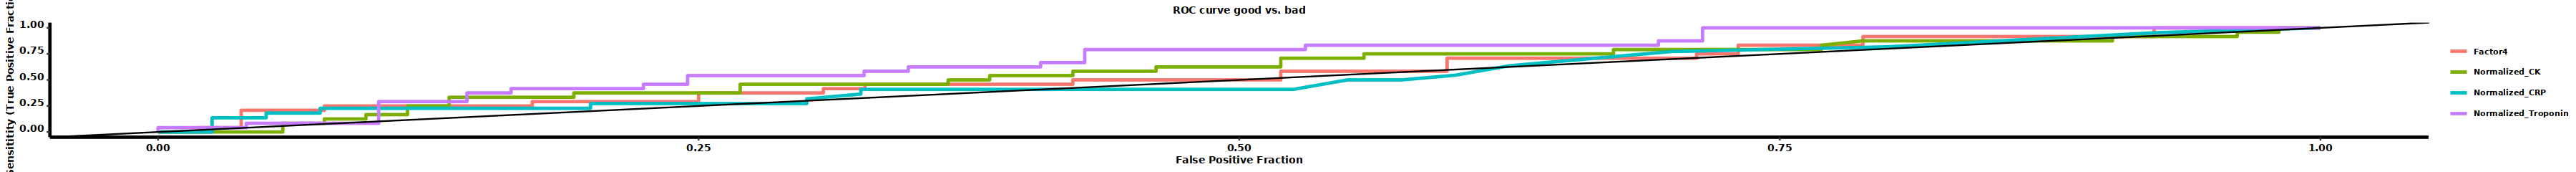

In [161]:
## Configuration + Modification of plot
roc_plot = rocplot + 
    plot_config + 
    xtitle + 
    ytitle + 
    ggtitle('ROC curve good vs. bad') +
    geom_abline(slope = 1, intercept = 0)

roc_plot

In [162]:
pdf(paste0('figures/Final_Figures/', figure_name, version, '.pdf'), width =width_par, height =height_par)
print(roc_plot)
dev.off()

png 
  2